In [2]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#load data

data = pd.read_csv('../../../data/processed/processed2.csv')

# print(data.head())
# Drop non-numeric columns (e.g., datetime)
data = data[['avg_30_min_demand', 'avg_temp']]

def create_sequences(data, seq_length):
    """
    Convert a 2D tensor of shape (total_samples, num_features) into 
    sequences of shape (num_sequences, seq_length, num_features)
    """
    sequences = []
    for i in range(len(data) - seq_length):
        # Get sequence of features
        seq = data[i:i+seq_length]
        sequences.append(seq)
    
    return torch.stack(sequences)

def create_targets(data, seq_length):
    """Create targets for each sequence (the next value after the sequence)"""
    targets = []
    for i in range(seq_length, len(data)):
        # For demand forecasting, you might want to predict only demand
        # target = data[i, 0]  # 0th column is demand
        # Or predict both features (less common)
        target = data[i]  # next full data point
        targets.append(target)
    
    return torch.stack(targets)

# Convert to numpy array and then to torch tensor
data_tensor = torch.tensor(data.values, dtype=torch.float32)
print(data.head())
print(data_tensor.shape)

# Create sequences
seq_length = 7
data_sequences = create_sequences(data_tensor, seq_length)
print(f"Data sequences shape: {data_sequences.shape}")

# Create targets (the next day's value after each sequence)
targets_demand = create_targets(data_tensor[:, 0:1], seq_length)

# Prepare Data
# 2. Scale the data (important for neural networks)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

scaled_data = scaler_X.fit_transform(data_tensor.numpy())
scaled_data = torch.FloatTensor(scaled_data)

# 3. Create sequences and targets
seq_length = 7
input_dim = 2  # demand and temperature

sequences = []
targets = []

for i in range(len(scaled_data) - seq_length):
    sequences.append(scaled_data[i:i+seq_length])  # sequence of 7 days
    targets.append(scaled_data[i+seq_length, 0])   # predict next day's demand (column 0)

sequences = torch.stack(sequences)
targets = torch.FloatTensor(targets).unsqueeze(1)  # shape: (n, 1)

print(f"Sequences shape: {sequences.shape}")  # torch.Size([1454, 7, 2])
print(f"Targets shape: {targets.shape}")      # torch.Size([1454, 1])

   avg_30_min_demand   avg_temp
0        6861.518333  20.704082
1        6731.957292  20.572917
2        6618.040000  21.130769
3        7358.550000  20.144444
4        7460.061875  18.904808
torch.Size([1461, 2])
Data sequences shape: torch.Size([1454, 7, 2])
Sequences shape: torch.Size([1454, 7, 2])
Targets shape: torch.Size([1454, 1])


In [ ]:
#helper functions and classes


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        # We add positional encoding for each element in the sequence
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        
        # Project input features to the model dimension
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Add positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Define a single Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='relu',
            batch_first=True  # Use (batch, seq, features) format
        )
        
        # Stack multiple encoder layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Final output layer: maps from d_model to 1 (predicting a single value)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        """
        Args:
            src: Input sequence. Shape: (batch_size, seq_len, input_dim)
            src_mask: Optional mask for the sequence to prevent attending to future tokens (not usually needed for encoder-only forecasting)
            src_key_padding_mask: Optional mask to ignore certain padding elements in the sequence
        Returns:
            output: Predictions. Shape: (batch_size, 1)
        """
        # Project input to d_model
        src_projected = self.input_projection(src) * math.sqrt(self.d_model)
        
        # Add positional encoding
        src_projected = self.pos_encoder(src_projected)
        
        # Pass through the transformer encoder
        # The encoder will output a representation for every token in the sequence
        # Shape: (batch_size, seq_len, d_model)
        encoder_output = self.transformer_encoder(src_projected, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        
        # We only care about the final token's representation to make the next prediction
        # We take the output corresponding to the last time step
        # Shape: (batch_size, d_model)
        last_time_step_output = encoder_output[:, -1, :]
        
        # Project to our output dimension (1)
        output = self.output_layer(last_time_step_output)
        
        # Use a linear activation for regression (NO softmax - that's for classification)
        # output shape: (batch_size, 1)
        return output

def train_transformer_model(sequences, targets, input_dim, seq_length):
    """
    Train the Transformer model
    """
    # 1. Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        sequences, targets, test_size=0.2, shuffle=False
    )
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_train_tensor = torch.FloatTensor(y_train)
    y_val_tensor = torch.FloatTensor(y_val)
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # 2. Initialize model, loss function, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = TransformerModel(
        input_dim=input_dim,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.1
    ).to(device)
    
    criterion = nn.MSELoss()  # Mean Squared Error for regression
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    # 3. Training parameters
    num_epochs = 100
    patience = 100
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    # Lists to store metrics
    train_losses = []
    val_losses = []
    
    # 4. Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(batch_X)
            
            # Calculate loss
            loss = criterion(predictions, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
        
        # Calculate average training loss
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                val_loss += loss.item() * batch_X.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_transformer_model.pth')
        else:
            epochs_no_improve += 1
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.6f}, '
                  f'Val Loss: {val_loss:.6f}, '
                  f'LR: {optimizer.param_groups[0]["lr"]:.2e}')
        
        # Early stopping
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # 5. Load the best model
    model.load_state_dict(torch.load('best_transformer_model.pth'))
    
    return model, train_losses, val_losses

def evaluate_model(model, X_val, y_val, device):
    """Evaluate the model on validation set"""
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_val).to(device)
        predictions = model(X_val_tensor)
        predictions = predictions.cpu().numpy()
    
    return predictions

def plot_results(train_losses, val_losses, y_val, predictions):
    """Plot training results and predictions"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training history
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title('Training History')
    ax1.legend()
    ax1.grid(True)
    
    # Plot predictions vs actual
    ax2.plot(y_val[:100], label='Actual', alpha=0.7)
    ax2.plot(predictions[:100], label='Predicted', alpha=0.7)
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Demand')
    ax2.set_title('Predictions vs Actual (First 100 samples)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

In [5]:
import torch
print(torch.cuda.is_available())   # should be True
print(torch.cuda.get_device_name(0))  # should print your GPU model


True
NVIDIA GeForce GTX 1650 Ti


Using device: cuda
Epoch [10/100], Train Loss: 0.413448, Val Loss: 0.289695, LR: 1.00e-03
Epoch [20/100], Train Loss: 0.325958, Val Loss: 0.259450, LR: 1.00e-03
Epoch [30/100], Train Loss: 0.320658, Val Loss: 0.242467, LR: 1.00e-03
Epoch [40/100], Train Loss: 0.265404, Val Loss: 0.223506, LR: 5.00e-04
Epoch [50/100], Train Loss: 0.238250, Val Loss: 0.218789, LR: 2.50e-04
Epoch [60/100], Train Loss: 0.208556, Val Loss: 0.226001, LR: 1.25e-04
Epoch [70/100], Train Loss: 0.205781, Val Loss: 0.233011, LR: 3.13e-05
Epoch [80/100], Train Loss: 0.192414, Val Loss: 0.230620, LR: 1.56e-05
Epoch [90/100], Train Loss: 0.206501, Val Loss: 0.228524, LR: 3.91e-06
Epoch [100/100], Train Loss: 0.200822, Val Loss: 0.228960, LR: 9.77e-07

Final Metrics:
MSE: 110613.2896
MAE: 241.5632
RMSE: 332.5858
MAPE: 3.0005


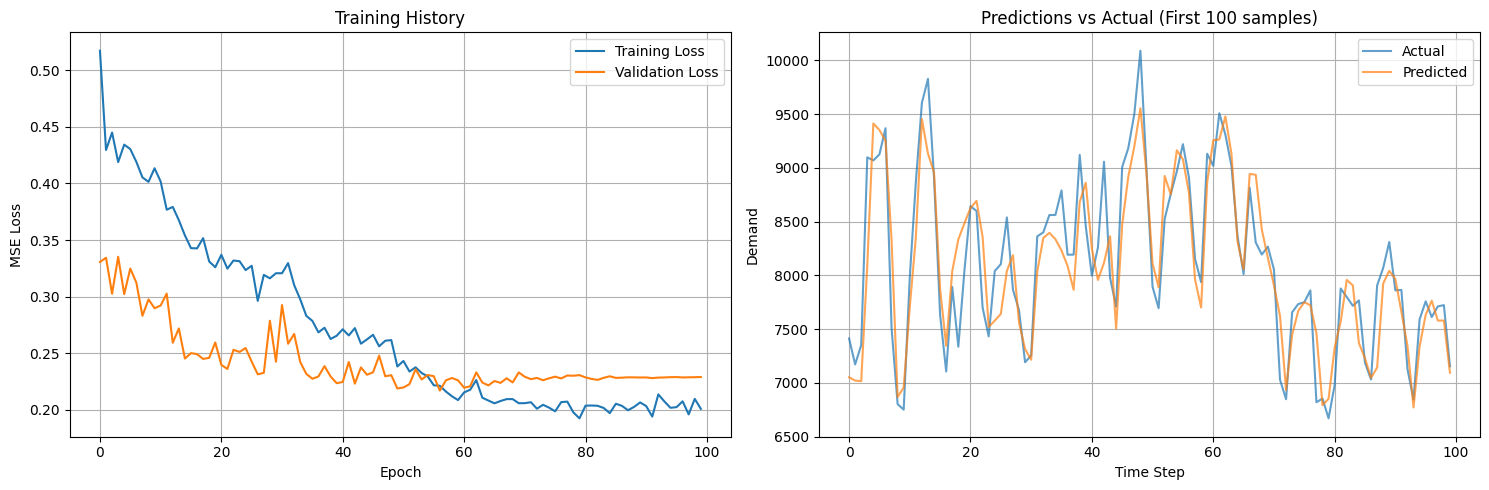

Training completed and model saved!


In [12]:

# 4. Train the model
model, train_losses, val_losses = train_transformer_model(
    sequences.numpy(), targets.numpy(), input_dim, seq_length
)

# 5. Evaluate and plot results
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictions = evaluate_model(model, sequences[-len(targets):].numpy(), 
                            targets.numpy(), device)

# Inverse transform predictions to original scale
# Create dummy array for inverse transform
dummy = np.zeros((len(predictions), 2))
dummy[:, 0] = predictions.flatten()
predictions_original = scaler_X.inverse_transform(dummy)[:, 0]

dummy[:, 0] = targets.numpy().flatten()
targets_original = scaler_X.inverse_transform(dummy)[:, 0]

# Calculate metrics
mse = np.mean((predictions_original - targets_original) ** 2)
mae = np.mean(np.abs(predictions_original - targets_original))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((predictions_original - targets_original) / targets_original)) * 100

print(f"\nFinal Metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")

# Plot results
plot_results(train_losses, val_losses, targets_original, predictions_original)

# 6. Save the final model
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'seq_length': seq_length,
    'input_dim': input_dim
}, 'final_transformer_model.pth')

print("Training completed and model saved!")